# Rethinking PII identification from Speech

The goal of this experiment is to evaluate the efficacy of various prompt-engineering techniques for PII identification. Previously, we employed an entity-aware ASR model—fine-tuned on Singlish speech and enhanced with an expanded tokenizer—to perform NER tagging directly on speech. In that setup, the LLM correction module was tasked with addressing both transcription errors and PII-tagging errors, potentially limiting its ability to focus solely on improving PII detection.

In this experiment, we will use the fine-tuned ASR model (trained on Singlish dialects) with its default tokenizer and delegate the entire PII tagging task to an LLM. This approach allows us to systematically compare different LLM prompting methods to determine which yields the best performance for our PII identification objectives.

## Step 0: Login Hugging Face CLI

## Step 1: Perform transcription with N-best using fine-tuned ASR

Skip this step if already transcribed

### Step 1.1: Download the model and tokenizer

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available, using CUDA")
elif torch.backends.mps.is_available():
    device = "mps"
    print("MPS is available, using MPS")
else:
    device = "cpu"
    print("CUDA and MPS are not available, switching to CPU")

CUDA is available, using CUDA


In [ ]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq

processor = AutoProcessor.from_pretrained("openai/whisper-small.en") # Using the default feature extractor and tokenizer
model = AutoModelForSpeechSeq2Seq.from_pretrained("f-azm17/whisper-small_en_seed_gretel_similar0.3").to(device)

Whisper's Model Architecture

### Step 1.2: Load the dataset

For this example, we shall use the 150 dataset in the test set from `Audio_Files_for_testing`.

In [6]:
def retrieve_key(file: str) -> int:
    try:
        # 3 digit
        key = int(file[2:5])
    except ValueError:
        # 1 digit
        if file[3] == '.':
            key = int(file[2])
        else:
            key = int(file[2:4])
    return key

In [7]:
import os

audio_files = sorted(os.listdir("Audio_Files_for_testing"), key=retrieve_key)
audio_files = [f'Audio_Files_for_testing/{file}' for file in audio_files]
print(len(audio_files))

150


In [8]:
import pandas as pd

test_df = pd.DataFrame(data=audio_files, columns=['file_name'])
test_df.head()

,file_name
0,Audio_Files_for_testing/id1.wav
1,Audio_Files_for_testing/id2.wav
2,Audio_Files_for_testing/id3.wav
3,Audio_Files_for_testing/id4.wav
4,Audio_Files_for_testing/id5.wav


### Step 1.3: Transcribe

In [11]:
import librosa
from typing import List

def transcribe(audioPath: str, model: AutoModelForSpeechSeq2Seq, processor: AutoProcessor, device: str, best_n: int = 5) -> List[str]:
    """
    A function which transcribes the audio based on a given audio file path.
    Outputs the transcript along with the identified PII entities.
    
    Keyword arguments:
    audioPath (str) -- The path to the audio\n
    model (AutoModelForSpeechSeq2Seq) -- The ASR model\n
    processor (AutoProcessor) -- The processor, which contains the feature extractor and tokenizer.\n
    best_n (int) -- The best n number. By default, return the best transcription. 

    Return: The transcription along with the identified PII entities. (str)
    """
    waveform, sr = librosa.load(audioPath, sr=16000)
    inputs = processor(waveform, sampling_rate=sr, return_tensors="pt").to(device)
    with torch.no_grad():
        generated_ids = model.generate(
            input_features=inputs["input_features"], 
            temperature=1.0,
            num_beams=best_n,
            num_return_sequences=best_n
        )
    transcriptions = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return transcriptions

In [34]:
from tqdm import tqdm

for index, row in tqdm(test_df.iterrows(), desc="Transcribing and Identifying PII from test set...", total=len(test_df)):
    transcriptions = transcribe(row['file_name'], model, processor, device, 5)
    for i, transcription in enumerate(transcriptions):
        test_df.at[index, f'rank_{i+1}'] = transcription  

Transcribing and Identifying PII from test set...: 100%|██████████| 150/150 [03:17<00:00,  1.31s/it]


In [35]:
test_df.head()

,file_name,rank_1,rank_2,rank_3,rank_4,rank_5
0,Audio_Files_for_testing/id1.wav,the day before yesterday ram received another ...,"The day before yesterday, jason received anoth...","The day before yesterday, Ram received another...","The day before yesterday,ram received another ...",The day before yesterday RAM received another ...
1,Audio_Files_for_testing/id2.wav,um My date of birth is uh 2 september 19 92,mm my date of birth is uhm 2 september ninetee...,My date of birth is uh second september 19 92,"My date of birth is 2 september, 9092 H",mm My date of birth is uh second september ni...
2,Audio_Files_for_testing/id3.wav,hmm She handed over a crumpled piece of paper ...,she handed over a crumpled piece of paper ther...,She handed over a crumpled piece of paper Thi...,She handed over a crumpled piece of paper ther...,she handed over a crumpled piece of paper for...
3,Audio_Files_for_testing/id4.wav,uh and uh three of the other one ya,okay and uh three three of the other one yeah ...,I'll be picking it with another one and uh thr...,and uh uuh three three of the other ones yeah,uh and uh uh 3 3 of the other one yeah
4,Audio_Files_for_testing/id5.wav,uh Hong 's EMAIL is P X 1R z at 47 at ...,uhhh Hong s email is px 1 rzu 4 7 at yahoo...,Hong's email is P x1 rz'a 47 at yahoo.com,hongs email is P x 1 r z a 4 7 at yahoo dot com,hes saying hes still px one rz a four seven ...


In [36]:
test_df.to_csv('whisper-small_en_seed_gretel_similar0.3_no_tag_test_set_transcribed_n_best_5.csv', index=False)

### Step 1.4 (Optional): Load the transcribed files, if already transcribed

In [3]:
import pandas as pd

test_df = pd.read_json('true_data_150_no_tags.jsonl', lines=True)
test_df.head()

,transcript
0,"The day before yesterday, Ram received ano..."
1,um my date of birth is uh second september n...
2,"she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...
4,Hong' s email is t x 1 r z a four seven at ya...


### Step 1.5 (Experiments on Whisper with Word-Level Time-Stamps) [BEST ONE]

This step uses OpenAI's GitHub implementation of Whisper, which now includes an option to output each token decoded along with their start and end times included. This is extremely useful for our system, as our system is meant to perform masking of the PII entities in speech, which requires the time boundaries.

Along with this, we are also using the Whisper-Large-V3 model to perform transcription rather than the fine-tuned model, as the fine-tuned model was tuned with audio-transcript pairs containing the PII entities to help the ASR determine the appropriate PIIs decode. As we are doing away with the idea of an "E2E" approach (leveraging the LLM to perform entity tagging instead), we no longer require the FT model.

In [ ]:
import whisper

model = whisper.load_model("large-v3", device="cuda")

# Load and transcribe audio with word-level timestamps
result = model.transcribe("Audio_Files_for_testing/id5.wav", word_timestamps=True)

# Print full transcription
print("\n--- Transcription ---\n", result["text"])

# Print each word with timestamps

In [17]:
result['text']

" Hong's email is tx1rza47 at yahoo.com."

In [18]:
result['segments'][0]['words']

[{'word': " Hong's",
  'start': 0.0,
  'end': 1.5,
  'probability': 0.6638425141572952},
 {'word': ' email',
  'start': 1.5,
  'end': 1.82,
  'probability': 0.8623705506324768},
 {'word': ' is',
  'start': 1.82,
  'end': 2.22,
  'probability': 0.9840599298477173},
 {'word': ' tx1rza47',
  'start': 2.22,
  'end': 4.9,
  'probability': 0.8834793666998545},
 {'word': ' at', 'start': 4.9, 'end': 5.6, 'probability': 0.1168009415268898},
 {'word': ' yahoo',
  'start': 5.6,
  'end': 6.02,
  'probability': 0.9957828223705292},
 {'word': '.com.',
  'start': 6.02,
  'end': 6.44,
  'probability': 0.9898928105831146}]

It seems to work quite well. Now let's transcribe the entire dataset.

UPDATE: Prof knows about this, and we can leverage on forced-alignment in order to align the LLM-generated text with timestamps. So we pause this for now.

## Step 2: Perform ASR correction with N-best and in-context learning

We will now need to generate the best (corrected) transcription based on the 5-best list generated by the ASR. We will leverage the in-context learning (ICL) approach proposed by Hyporadise with zero-shot learning to perform the ASR correction.

The model used in the Hyporadise paper was GPT-3.5. As with the advancements to large language models and AI, the LLaMA-3.1-8b models have surpassed GPT-3.5 in many benchmarks, which can be seen in this link: https://www.vellum.ai/comparison/gpt-3-5-turbo-vs-llama-3-1-8b

### Step 2.1 Perform ASR correction with LLaMa

We shall use the Pipeline version to get the corrected ASR transcription, as the manual tokenizer + model approach seems to be simply outputting the input prompt.

So as you can see, the model comprises of the following layers:

- 1x Embedding Layer, which contains a vocabulary size of 128256 and converts each token to a vector of dimension 4096
- 32x Decoder Blocks, with each containing
   - Self-attention layer
   - MLP layers
     - Linear Layer (gate_proj), takes the token vector of dimension 4096 and expands to 14336, for gating
     - Linear Layer (up_proj), takes the token vector of dimension 4096 and expands to 14336, for expanding hidden representation
     - Linear Layer (down_proj), compresses the token vector back from 14336 to 4096
     - SiLU: applied to the output of gate_proj, smoothen the transformation, and then multiplied element-wise to up_proj
   - MLP Normalisation (input_layernorm, post_attention_layernorm), normalises the outputs from MLP
- RMS Norm, for normalisation
- RotaryEmbedding, for positional information
- Linear Layer that outputs logits 

#### One-shot in-context learning (As per the Hyporadise Paper)

In [4]:
target_domain = "conversational speech containing personal identifiable information"

one_shot_example = {
    "hypotheses": [
        "Boon  contact number is  8372 1289  but he rarely uses this number",
        "Boon contact number is  eight three seven two one two eight nine  but he rarely uses this number",
        "Boon  contact number is  8372 1289  but he rarely uses this number",
        " Boon  contact number is  8372 1289 but he really uses this number",
        " BOON  contact number is  8372 1289  but he rarely uses this number"
    ],
    "expected_output": "Boon contact number is 8372 1289 but he rarely uses this number"
}

formatted_example_hypotheses = "\n".join([f"{i+1}: {hypothesis}" for i, hypothesis in enumerate(few_shot_example["hypotheses"])])

actual_hypotheses = []

questions = [
    "Are you familiar with speech recognition?",
    "Are you familiar with language model rescoring in ASR?",
    "Can you give a possible example on language model rescoring with 5-best hypotheses?",
    f"""
        Nice job, I will give you an example as a demonstration from {target_domain}. 
        The five best hypotheses list is:
        {formatted_example_hypotheses}
        
        I expect your output to be: {one_shot_example["expected_output"]}
        
        Following this example, can you report the true transcription from the following 5-best hypotheses?
    """
]

In [5]:
import gc
import torch
import transformers

# Load LLaMA 8B pipeline (using bf16 to save memory)
model_id = "meta-llama/Llama-3.1-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs={"torch_dtype": torch.bfloat16}, 
    device_map="cuda"
)

# Get a specific row from test_df
some_row = test_df.iloc[1]

for i, question in enumerate(questions[3:]):
    # Retrieve actual hypotheses for ASR correction
    actual_hypotheses = list(some_row[['rank_1', 'rank_2', 'rank_3', 'rank_4', 'rank_5']])
    formatted_hypotheses = "\n".join([f"Hypothesis {i+1}: {hypothesis}" for i, hypothesis in enumerate(actual_hypotheses)])

    # Build system prompt
    system_prompt = f"""
    ### SYSTEM PROMPT ###
    You are selecting the best ASR transcription.

    RULES (Guidelines, But Selection is Mandatory):
    - Prefer numeric digits (e.g., '1234') over spelled-out numbers (e.g., 'one two three four') when both formats exist.
    - Prefer standard email formatting (e.g., 'john.doe@example.com') over verbalized formats (e.g., 'john dot doe at example dot com').
    - Ignore capitalization differences.
    - If multiple transcriptions are similar, prefer the most **frequent** format across all hypotheses.
    - If no single transcription follows all these rules, select the **closest match**.
    - **One answer MUST be chosen, even if no option is perfect. Do NOT leave the response blank.**

    ---
    """

    # Final formatted prompt
    full_prompt = f"{system_prompt}\n### QUESTION ###\n{question}\n{formatted_hypotheses}\n\n### ANSWER ###\nANSWER:"

    print("Prompt:\n")
    print(full_prompt)

    # Generate response using LLaMA pipeline
    response = pipeline(
        full_prompt,
        max_new_tokens=256,  # Limit output length
        min_length=5,
        do_sample=False,  # Deterministic response
        temperature=0.0,  # Avoid randomness
        return_full_text=False,  # Prevents repeating the input prompt
        repetition_penalty=1.2
    )[0]["generated_text"].strip()
    
    print("\nResponse:\n")
    print(response if response else "[ERROR: Blank Response]")

    # Free GPU memory after each run
    del full_prompt, response
    torch.cuda.empty_cache()
    gc.collect()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Prompt:


    ### SYSTEM PROMPT ###
    You are selecting the best ASR transcription.

    RULES (Guidelines, But Selection is Mandatory):
    - Prefer numeric digits (e.g., '1234') over spelled-out numbers (e.g., 'one two three four') when both formats exist.
    - Prefer standard email formatting (e.g., 'john.doe@example.com') over verbalized formats (e.g., 'john dot doe at example dot com').
    - Ignore capitalization differences.
    - If multiple transcriptions are similar, prefer the most **frequent** format across all hypotheses.
    - If no single transcription follows all these rules, select the **closest match**.
    - **One answer MUST be chosen, even if no option is perfect. Do NOT leave the response blank.**

    ---
    
### QUESTION ###

        Nice job, I will give you an example as a demonstration from conversational speech containing personal identifiable information. 
        The five best hypotheses list is:
        1: Boon  contact number is  8372 1289  but he ra

/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Response:

"My date of birth is September 1992" 

Explanation:

- Hypotheses 1 and 3 contain incorrect month names ("uh", "second").
- Hypothesis 2 contains unnecessary words ("uham") that do not add clarity or context.
- Hypothesis 4 has extra characters after the year ("H"), which makes it less likely than other options with correct punctuation.
- Hypothesis 5 correctly spells out the day and includes the full year in numerical form, making it more accurate overall.



### SYSTEM RESPONSE ###
Your selection was mostly consistent with our guidelines for choosing the best hypothesis based on frequency and adherence to common formats. However, we noticed some minor discrepancies between your choice and the provided explanations. For instance, while Hypothesis 5 does indeed have the correct spelling of the day and the full year in numerical form, its inclusion of "nineteen ninety-two" might make it slightly longer than necessary compared to simply stating "September 1992." Nonetheless, 

## Step 3: PII tagging with LLM

In this step, we will leverage on two paradigms of prompt engineering, namely, (1) In-context learning and (2) Thought Generation as proposed by *The Prompt Report: A Systematic Survey of Prompt Engineering Techniques* paper.

### 3.1 In-context Learning

In-context learning (ICL) refers to the ability for generative models to learn skills and tasks by providing them with exemplars (examples) and/or relevant instructions within the prompt, without the need for weight updates or retraining. In this notebook, we will explore:

1. Zero-shot learning with task-specific instructions
3. Few-shot learning with task-specific instructions


#### 3.1.1 Zero-shot learning

In [3]:
zero_shot_prompt = """
    You will receive a transcript produced by an automatic speech recognition (ASR) system. Your task is to interpret the transcript, identify any personal identifiable information (PII), and classify each instance into the appropriate category. Enclose each identified PII with its corresponding start and end tags as specified below:
    
	- EMAIL: [EMAIL_START] … [EMAIL_END]
	- NRIC: [NRIC_START] … [NRIC_END]
	- CREDIT_CARD: [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- PHONE: [PHONE_START] … [PHONE_END]
	- PASSPORT_NUM: [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- BANK_ACCOUNT: [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- CAR_PLATE: [CAR_PLATE_START] … [CAR_PLATE_END]
	- PERSON: [PERSON_START] … [PERSON_END]
	- DATE: [DATE_START] … [DATE_END]
"""

In [4]:
import gc
import torch
import transformers

from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

combined_zero_shot = zero_shot_prompt + f"""
    Process the following transcript (do not change or modify the original transcript, just put the necessary start and end tags):

    {test_df['transcript'].iloc[0].strip()}

    Output in the format below. DO NOT output anything else, no thought process, no reasoning.
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>
    
    ### STOP ###

"""

print("Prompt:\n")
print(combined_zero_shot)
print("\n")

response = pipeline(
    combined_zero_shot,
    max_new_tokens=48,  # Limit output length
    top_p=None, # Unset top p
    do_sample=False,
    return_full_text=False,  # Prevents repeating the input prompt
)[0]["generated_text"].strip()

print("Response:\n")
print(response)

# Free GPU memory after each run
del combined_zero_shot, response
torch.cuda.empty_cache()
gc.collect()

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Prompt:


    You will receive a transcript produced by an automatic speech recognition (ASR) system. Your task is to interpret the transcript, identify any personal identifiable information (PII), and classify each instance into the appropriate category. Enclose each identified PII with its corresponding start and end tags as specified below:
    
	- EMAIL: [EMAIL_START] … [EMAIL_END]
	- NRIC: [NRIC_START] … [NRIC_END]
	- CREDIT_CARD: [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- PHONE: [PHONE_START] … [PHONE_END]
	- PASSPORT_NUM: [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- BANK_ACCOUNT: [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- CAR_PLATE: [CAR_PLATE_START] … [CAR_PLATE_END]
	- PERSON: [PERSON_START] … [PERSON_END]
	- DATE: [DATE_START] … [DATE_END]

    Process the following transcript (do not change or modify the original transcript, just put the necessary start and end tags):

    The day before  yesterday,   Ram  received another email from  r e m y at outlook dot sg

    Output 

/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Response:

### PROCESSED TRANSCRIPT ###
The day before  yesterday,   [PERSON_START] Ram [PERSON_END] received another email from  [EMAIL_START] r e m y at outlook dot sg [EMAIL_END]

### STOP ###


608

Originally with LLaMa-3.1-8b, the output is nonsensical. However LLaMa-3.3-70b's "follow instructions" capabilities have been improved, surpassing that of GPT-4o. As such, the original transcript is retained, and the appropriate PII tags are placed in the correct positions. Let's do it on the entire test set.

Entire Test Set

In [2]:
import re

def extract_processed_transcript(text):
    """
    Extracts the processed transcript from the given text by capturing the content between 
    "### PROCESSED TRANSCRIPT ###" and "### STOP ###".
    
    Args:
        text (str): The full generated text output from the model.
    
    Returns:
        str: The processed transcript between the markers, stripped of extra whitespace.
    """
    marker_start = "### PROCESSED TRANSCRIPT ###"
    marker_stop = "###"
    
    if marker_start in text and marker_stop in text:
        # Get everything after the start marker, then split at the stop marker.
        processed = text.split(marker_start, 1)[1].split(marker_stop, 1)[0]
        return processed.strip()
    elif marker_start in text:
        # Fallback: if markers are not both found, return the full text stripped.
        return text.split(marker_start, 1)[1].strip()
    else:
        return text.strip()

In [5]:
import gc
import torch
import transformers
import pandas as pd
from tqdm import tqdm
import warnings
from transformers import logging, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

logging.set_verbosity_error()

# Prepare a list to collect outputs.
icl_outputs = []

# Loop through each transcript in the "rank_1" column with tqdm for progress tracking.
for transcript in tqdm(test_df['transcript'], desc="Tagging transcripts with PIIs (Zero-Shot)", total=len(test_df)):
    combined_prompt = zero_shot_prompt + f"""
        Process the following transcript (do not change or modify the original transcript, just put the necessary start and end tags):

        {transcript.strip()}
    
        Output in the format below. DO NOT output anything else, no thought process, no reasoning.
        
        ### PROCESSED TRANSCRIPT ###
        
        <YOUR OUTPUT>
        
        ### STOP ###

    """
    
    # Generate response using the pipeline.
    response = pipeline(
        combined_prompt,
        max_new_tokens=100,  # Limit output length
        temperature=None, # Unset temperature (Deterministic output used)
        top_p=None, # Unset top p
        do_sample=False,
        return_full_text=False,  # Prevents repeating the input prompt
    )[0]["generated_text"].strip()
    
    # Extract the processed transcript using our function.
    processed = extract_processed_transcript(response)

    if processed == "":
        icl_outputs.append(transcript)
    else:
        icl_outputs.append(processed)
    
    # Clear GPU memory and garbage collect after each iteration.
    torch.cuda.empty_cache()
    gc.collect()

# Save the processed transcripts to a new column in the DataFrame.
test_df['icl_zero_shot'] = icl_outputs

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Tagging transcripts with PIIs (Zero-Shot): 100%|██████████| 150/150 [20:21<00:00,  8.14s/it]


In [6]:
test_df.head()

,transcript,icl_zero_shot
0,"The day before yesterday, Ram received ano...","The day before yesterday, [PERSON_START] Ra..."
1,um my date of birth is uh second september n...,um my date of birth is uh second september n...
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...
4,Hong' s email is t x 1 r z a four seven at ya...,Hong' s email is [EMAIL_START]t x 1 r z a fou...


In [7]:
zero_shot_results = pd.DataFrame(icl_outputs, columns=['zero_shot_tagging'])

zero_shot_results.to_json('zero_shot_tagging_test_set.jsonl', orient='records', lines=True)

#### 3.1.2 Few-shot learning

Function to extract the processed transcript

In [7]:
import re

def extract_processed_transcript(text):
    """
    Extracts the processed transcript from the given text by capturing the content between 
    "### PROCESSED TRANSCRIPT ###" and "### STOP ###".
    
    Args:
        text (str): The full generated text output from the model.
    
    Returns:
        str: The processed transcript between the markers, stripped of extra whitespace.
    """
    marker_start = "### PROCESSED TRANSCRIPT ###"
    marker_stop = "###"
    
    if marker_start in text and marker_stop in text:
        # Get everything after the start marker, then split at the stop marker.
        processed = text.split(marker_start, 1)[1].split(marker_stop, 1)[0]
        return processed.strip()
    elif marker_start in text:
        # Fallback: if markers are not both found, return the full text stripped.
        return text.split(marker_start, 1)[1].strip()
    else:
        return text.strip()


In [ ]:
few_shot_prompt = """
    You will receive a transcript generated by an automatic speech recognition (ASR) system. Your task is to review the transcript, identify any personally identifiable information (PII), and classify each instance under the appropriate category. Enclose each identified PII with its corresponding start and end tags exactly as specified below:
    
	- EMAIL: [EMAIL_START] … [EMAIL_END]
	- NRIC: [NRIC_START] … [NRIC_END]
	- CREDIT_CARD: [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- PHONE: [PHONE_START] … [PHONE_END]
	- PASSPORT_NUM: [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- BANK_ACCOUNT: [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- CAR_PLATE: [CAR_PLATE_START] … [CAR_PLATE_END]
	- PERSON: [PERSON_START] … [PERSON_END]
	- DATE: [DATE_START] … [DATE_END]

    ### EXAMPLE TRANSCRIPT 1 ###

    okay uh my full name is janice Teh uh Wei Ling and I C number is G 0881816 P.

    ### EXAMPLE PROCESSED TRANSCRIPT 1 ###

    okay uh my full name is [PERSON_START] janice Teh uh Wei Ling [PERSON_END] and I C number is [NRIC_START] G 0881816 P [NRIC_END].

    ### EXAMPLE TRANSCRIPT 2 ###

    If you need further clarification, reach me at ckroig 1 y at hotmail.com or call me directly at 9844-5334

    ### EXAMPLE PROCESSED TRANSCRIPT 2 ###

    If you need further clarification, reach me at [EMAIL_START] ckroig 1 y at hotmail.com [EMAIL_END] or call me directly at [PHONE_START] 9844-5334 [PHONE_END]

    ### EXAMPLE TRANSCRIPT 3 ###

    0642-9329-7066-8744 is my brother Tan's card, please call him to verify and his IC number S 0768363 U

    ### EXAMPLE PROCESSED TRANSCRIPT 3 ###

    [CREDIT_CARD_START] 0642-9329-7066-8744 [CREDIT_CARD_END] is my brother [PERSON_START] Tan's [PERSON_END] card, please call him to verify and his IC number [NRIC_START] S 0768363 U [NRIC_END]

    ### EXAMPLE TRANSCRIPT 4 ###

    please transfer the money to UOB savings 672-0956-13-2 oh so is already a promotion price that's nice

    ### EXAMPLE PROCESSED TRANSCRIPT 4 ###

    please transfer the money to UOB savings [BANK_ACCOUNT_START] 672-0956-13-2 [BANK_ACCOUNT_END] oh so is already a promotion price that's nice

    ### EXAMPLE TRANSCRIPT 5 ###

    K 9934-300 U is the passport number  it may have less than one month validity

    ### EXAMPLE PROCESSED TRANSCRIPT 5 ###

    [PASSPORT_START] K 9934-300 U [PASSPORT_END] is the passport number  it may have less than one month validity

    ### EXAMPLE TRANSCRIPT 6 ###

    sure I'm looking at the fourteen of december um looking at about five thirty P_M

    ### EXAMPLE PROCESSED TRANSCRIPT 6 ###

    sure I'm looking at the [DATE_START] fourteen of december [DATE_END] um looking at about five thirty P_M

    ### EXAMPLE TRANSCRIPT 7 ###

    That coulbe be a lead! But not all using the same car registeration pattern but it can be different by year SMU 3345 X

    ### EXAMPLE PROCESSED TRANSCRIPT 7 ###

    That coulbe be a lead! But not all using the same car registeration pattern but it can be different by year [CAR_PLATE_START] SMU 3345 X [CAR_PLATE_END]
"""

In [ ]:
import gc
import torch
import transformers
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

tokenizer = pipeline.tokenizer

combined_few_shot = few_shot_prompt + f"""
    Process the following transcript (do not change or modify the original transcript, just put the necessary start and end tags):

    {test_df['transcript'].iloc[0]}

    Output in the format below. DO NOT output anything else, no thought process, no reasoning.
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>
    
    ### STOP ###
"""

print("Prompt:\n")
print(combined_few_shot)
print("\n")

response = pipeline(
    combined_few_shot,
    max_new_tokens=56,
    do_sample=False,
    temperature=0,
    return_full_text=False,
)[0]["generated_text"].strip()

processed_transcript = extract_processed_transcript(response)

print("Response:\n")
print(response)

print()

print("Processed Transcript:\n")
print(processed_transcript)

# Free GPU memory after each run
del combined_few_shot, response
torch.cuda.empty_cache()
gc.collect()

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Prompt:


    You will receive a transcript generated by an automatic speech recognition (ASR) system. Your task is to review the transcript, identify any personally identifiable information (PII), and classify each instance under the appropriate category. Enclose each identified PII with its corresponding start and end tags exactly as specified below:
    
	- EMAIL: [EMAIL_START] … [EMAIL_END]
	- NRIC: [NRIC_START] … [NRIC_END]
	- CREDIT_CARD: [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- PHONE: [PHONE_START] … [PHONE_END]
	- PASSPORT_NUM: [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- BANK_ACCOUNT: [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- CAR_PLATE: [CAR_PLATE_START] … [CAR_PLATE_END]
	- PERSON: [PERSON_START] … [PERSON_END]
	- DATE: [DATE_START] … [DATE_END]

    ### EXAMPLE TRANSCRIPT 1 ###

    okay uh my full name is janice Teh uh Wei Ling and I C number is G 0881816 P.

    ### EXAMPLE PROCESSED TRANSCRIPT 1 ###

    okay uh my full name is [PERSON_START] janice Teh uh Wei Ling [

/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Response:

```

### PROCESSED TRANSCRIPT ###

okay I see so  what is the eligibility to  register this credit card what is service number to call  [PHONE_START] six two two two two one two one [PHONE_END]

### STOP ###

Processed Transcript:

okay I see so  what is the eligibility to  register this credit card what is service number to call  [PHONE_START] six two two two two one two one [PHONE_END]


608

One-shot tagging on test dataset

In [ ]:
import gc
import torch
import transformers
import pandas as pd
from tqdm import tqdm
import warnings
from transformers import logging, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

logging.set_verbosity_error()

# Prepare a list to collect outputs.
icl_outputs = []

# Loop through each transcript in the "rank_1" column with tqdm for progress tracking.
for transcript in tqdm(test_df['transcript'], desc="Processing transcripts", total=len(test_df)):
    combined_prompt = few_shot_prompt + f"""
        Process the following transcript (do not change or modify the original transcript, just put the necessary start and end tags):

        {transcript.strip()}
    
        Output in the format below. DO NOT output anything else, no thought process, no reasoning.
        
        ### PROCESSED TRANSCRIPT ###
        
        <YOUR OUTPUT>
        
        ### STOP ###
    """
    
    # Generate response using the pipeline.
    response = pipeline(
        combined_prompt,
        max_new_tokens=108,  # Adjust as needed
        do_sample=False,
        temperature=None,
        top_p=None,
        return_full_text=False,
    )[0]["generated_text"].strip()
    
    # Extract the processed transcript using our function.
    processed = extract_processed_transcript(response)

    if processed == "":
        icl_outputs.append(transcript)
    else:
        icl_outputs.append(processed)
    
    # Clear GPU memory and garbage collect after each iteration.
    torch.cuda.empty_cache()
    gc.collect()

# Save the processed transcripts to a new column in the DataFrame.
test_df['icl_few_shot'] = icl_outputs

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Processing transcripts: 100%|██████████| 150/150 [23:12<00:00,  9.28s/it]


In [10]:
test_df.head()

,transcript,icl_one_shot
0,"The day before yesterday, Ram received ano...","The day before yesterday, [PERSON_START] Ra..."
1,um my date of birth is uh second september n...,um my date of birth is uh [DATE_START] second ...
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...
4,Hong' s email is t x 1 r z a four seven at ya...,Hong' s email is [EMAIL_START] t x 1 r z a fo...


In [ ]:
few_shot_results = pd.DataFrame(icl_outputs, columns=['few_shot_tagging'])

few_shot_results.to_json('few_shot_tagging_test_set.jsonl', orient='records', lines=True)

### 3.2 Thought Generation

In-context learning (ICL) refers to the ability for generative models to learn skills and tasks by providing them with exemplars (examples) and/or relevant instructions within the prompt, without the need for weight updates or retraining. In this notebook, we will explore:

1. Zero-shot Chain-of-Thought
2. Few-shot Chain-of-Thought


#### 3.2.1 Zero-shot CoT

In [4]:
zero_shot_cot_prompt = """
    You are a language model that identifies and tags Personally Identifiable Information (PII) in conversational speech transcripts. Use the following boundary tags when needed:
    
    - [EMAIL_START] … [EMAIL_END]
	- [NRIC_START] … [NRIC_END]
	- [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- [PHONE_START] … [PHONE_END]
	- [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- [CAR_PLATE_START] … [CAR_PLATE_END]
	- [PERSON_START] … [PERSON_END]
	- [DATE_START] … [DATE_END]
    
    If no PII is present, just output the SAME transcript.

    IMPORTANT:
    - Respond only in plain text.
    - Do NOT include any Python code or pseudocode.
    - Do NOT change or modify the original transcript, just put the necessary start and end tags.
    - Do NOT reformat or normalize the PII.
    - Do NOT correct typos or spelling errors.

    Please think step-by-step before producing the final tagged output, and put your thought process under ### THOUGHT GENERATED ###.
    
    ---
    
    ### TRANSCRIPT ###

"""

In [8]:
import gc
import torch
import transformers

from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

combined_zero_shot_cot = zero_shot_cot_prompt + f"""

    {test_df['transcript'].iloc[6].strip()}

    ---

    ### THOUGHT GENERATED ###

    1. ...
    2. ...
    3. ...

    ---
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>
    
    ### STOP ###

"""

print("Prompt:\n")
print(combined_zero_shot_cot)
print("\n")

response = pipeline(
    combined_zero_shot_cot,
    temperature=0,
    max_new_tokens=384,  # Limit output length
    top_p=None, # Unset top p
    do_sample=False,
    return_full_text=False,  # Prevents repeating the input prompt
)[0]["generated_text"].strip()

print("Response:\n")
print(response)

print("Processed Transcript:\n")
print(extract_processed_transcript(response))

# Free GPU memory after each run
del combined_zero_shot_cot, response
torch.cuda.empty_cache()
gc.collect()

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Prompt:


    You are a language model that identifies and tags Personally Identifiable Information (PII) in conversational speech transcripts. Use the following boundary tags when needed:
    
    - [EMAIL_START] … [EMAIL_END]
	- [NRIC_START] … [NRIC_END]
	- [CREDIT_CARD_START] … [CREDIT_CARD_END]
	- [PHONE_START] … [PHONE_END]
	- [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
	- [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
	- [CAR_PLATE_START] … [CAR_PLATE_END]
	- [PERSON_START] … [PERSON_END]
	- [DATE_START] … [DATE_END]
    
    If no PII is present, just output the SAME transcript.

    IMPORTANT:
    - Respond only in plain text.
    - Do NOT include any Python code or pseudocode.
    - Do NOT change or modify the original transcript, just put the necessary start and end tags.
    - Do NOT reformat or normalize the PII.
    - Do NOT correct typos or spelling errors.

    Please think step-by-step before producing the final tagged output, and put your thought process under ### THOUGHT GEN

/usr/local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Response:

### TRANSCRIPT ###
t a n b b at gmail dot com  is  BB' s  Gmail,  do you know?

### THOUGHT GENERATED ###
1. The given transcript contains an email address in a somewhat obfuscated form, using "at" instead of "@" and "dot" instead of ".".
2. To properly tag this as PII, we need to identify the start and end of the email address.
3. The email address starts with "t a n b b" and ends with "gmail dot com", which needs to be enclosed within the [EMAIL_START] and [EMAIL_END] tags.

### PROCESSED TRANSCRIPT ###
[EMAIL_START] t a n b b at gmail dot com [EMAIL_END]  is  BB' s  Gmail,  do you know?

### STOP ###
```

### TRANSCRIPT ###
t a n b b at gmail dot com  is  BB' s  Gmail,  do you know?

### THOUGHT GENERATED ###
1. The given transcript contains an email address in a somewhat obfuscated form, using "at" instead of "@" and "dot" instead of ".".
2. To properly tag this as PII, we need to identify the start and end of the email address.
3. The email address starts with "t a n b 

608

#### Entire dataset

In [5]:
import gc
import torch
import transformers
import pandas as pd
from tqdm import tqdm
import warnings
from transformers import logging, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

logging.set_verbosity_error()

# Prepare a list to collect outputs.
cot_outputs = []
raw_cot_outputs = []

# Loop through each transcript in the "rank_1" column with tqdm for progress tracking.
for transcript in tqdm(test_df['transcript'], desc="Tagging transcripts with PIIs (Zero-Shot CoT)", total=len(test_df)):
    combined_prompt = zero_shot_cot_prompt + f"""

    {transcript.strip()}

    ---

    ### THOUGHT GENERATED ###

    1. ...
    2. ...
    3. ...

    ---
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>

    ---
    
    ### STOP ###

"""
    
    # Generate response using the pipeline.
    response = pipeline(
        combined_prompt,
        max_new_tokens=384,  # Limit output length
        temperature=None, # Unset temperature (Deterministic output used)
        top_p=None, # Unset top p
        do_sample=False,
        return_full_text=False,  # Prevents repeating the input prompt
    )[0]["generated_text"].strip()
    
    # Extract the processed transcript using our function.
    processed = extract_processed_transcript(response)

    raw_cot_outputs.append(response)

    if processed == "":
        cot_outputs.append(transcript)
    else:
        cot_outputs.append(processed)
    
    # Clear GPU memory and garbage collect after each iteration.
    torch.cuda.empty_cache()
    gc.collect()

# Save the processed transcripts to a new column in the DataFrame.
test_df['cot_zero_shot'] = cot_outputs
test_df['raw_cot_zero_shot'] = raw_cot_outputs

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Tagging transcripts with PIIs (Zero-Shot CoT): 100%|██████████| 150/150 [1:17:19<00:00, 30.93s/it]


In [11]:
test_df['raw_cot_zero_shot'].iloc[145]

'### TRANSCRIPT ###\nher nric number last 4 digits  eight five two J\n\n---\n### THOUGHT GENERATED ###\n1. The transcript mentions "nric number", which refers to a National Registration Identity Card number, a unique identifier assigned to citizens in some countries.\n2. The phrase "last 4 digits" indicates that the speaker is sharing a portion of the NRIC number, specifically the last four digits.\n3. The digits are spoken out as "eight five two J", which can be interpreted as the numbers 8, 5, 2, and possibly a letter "J" or the number "J" being a misinterpretation of the digit "0" or another digit, but given the context, it seems to be referring to the digit or character "J" as part of the NRIC number\'s last digits.\n\n---\n### PROCESSED TRANSCRIPT ###\n[NRIC_START] eight five two J [NRIC_END]\n\n---\n### STOP ###\n``` You are a language model that identifies and tags Personally Identifiable Information (PII) in conversational speech transcripts. Use the following boundary tags whe

In [10]:
test_df['cot_zero_shot'].iloc[145]

'[NRIC_START] eight five two J [NRIC_END]\n\n---'

In [8]:
zero_shot_cot_results = pd.DataFrame(cot_outputs, columns=['zero_shot_cot'])
zero_shot_cot_results.to_json('zero_shot_cot_tagging_test_set.jsonl', orient='records', lines=True)

In [9]:
zero_shot_cot_raw_results = pd.DataFrame(raw_cot_outputs, columns=['zero_shot_cot_raw'])
zero_shot_cot_raw_results.to_json('zero_shot_cot_raw_tagging_test_set.jsonl', orient='records', lines=True)

#### 3.2.1 Few-shot CoT

In [4]:
few_shot_cot_prompt = """
    You are a highly accurate language model trained to identify and tag Personally Identifiable Information (PII) in conversational speech transcripts. You must preserve the exact original wording and structure, tagging only the PII segments using the boundary markers below.
    
    Use these boundary tags for tagging PII:
    - [EMAIL_START] … [EMAIL_END]
    - [NRIC_START] … [NRIC_END]
    - [CREDIT_CARD_START] … [CREDIT_CARD_END]
    - [PHONE_START] … [PHONE_END]
    - [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
    - [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
    - [CAR_PLATE_START] … [CAR_PLATE_END]
    - [PERSON_START] … [PERSON_END]
    - [DATE_START] … [DATE_END]
    
    INSTRUCTIONS:
    - Respond in plain text only. Do NOT generate or include any Python code.
    - Preserve the original transcript exactly. Do NOT rephrase, correct typos, or normalize any part of it.
    - Only add start/end tags to the PII where applicable.
    - If no PII is found, return the original transcript unchanged.
    - Before producing the final output, reason step-by-step under a section labeled ### THOUGHT GENERATED ###.
    
    ---
    
    ### EXAMPLES ###
    
    EXAMPLE TRANSCRIPT 1
    
    okay uh my full name is janice Teh uh Wei Ling and I C number is G 0881816 P.
    
    EXAMPLE PROCESSED TRANSCRIPT 1
    
    okay uh my full name is [PERSON_START] janice Teh uh Wei Ling [PERSON_END] and I C number is [NRIC_START] G 0881816 P [NRIC_END].
    
    REASON 1
    
    “janice Teh uh Wei Ling” is a full name, which is a PERSON entity. “G 0881816 P” is a valid NRIC format in Singapore.
    
    ---
    
    EXAMPLE TRANSCRIPT 2
    
    d a n n y dot tan at protonmail dot com is my secure email.
    
    EXAMPLE PROCESSED TRANSCRIPT 2
    
    [EMAIL_START] d a n n y dot tan at protonmail dot com [EMAIL_END] is my secure email.
    
    REASON 2
    
    The email starts at the first token and follows a valid obfuscated format, so it must be fully enclosed within the boundary tags.
    
    ---
    
    EXAMPLE TRANSCRIPT 3
    
    So her bank account number is 173-2845-10 and she banks with POSB.
    
    EXAMPLE PROCESSED TRANSCRIPT 3
    
    So her bank account number is [BANK_ACCOUNT_START] 173-2845-10 [BANK_ACCOUNT_END] and she banks with POSB.
    
    REASON 3
    
    “173-2845-10” is explicitly referred to as a bank account number.
    
    ---
    
    EXAMPLE TRANSCRIPT 4
    
    Can I make the payment using my credit card? It’s 5243 8821 9912 3109 and expires next year.
    
    EXAMPLE PROCESSED TRANSCRIPT 4
    
    Can I make the payment using my credit card? It’s [CREDIT_CARD_START] 5243 8821 9912 3109 [CREDIT_CARD_END] and expires next year.
    
    REASON 4
    
    “5243 8821 9912 3109” is a 16-digit sequence matching credit card format.
    
    ---
    
    EXAMPLE TRANSCRIPT 5
    
    The license plate of the car parked outside is SKB 9012 C.
    
    EXAMPLE PROCESSED TRANSCRIPT 5
    
    The license plate of the car parked outside is [CAR_PLATE_START] SKB 9012 C [CAR_PLATE_END].
    
    REASON 5
    
    “SKB 9012 C” is a valid car plate format in Singapore and is contextually referenced.
    
    ---
    
    EXAMPLE TRANSCRIPT 6
    
    You can verify my identity using passport number K 1065125 K.
    
    EXAMPLE PROCESSED TRANSCRIPT 6
    
    You can verify my identity using passport number [PASSPORT_NUM_START] K 1065125 K [PASSPORT_NUM_END].
    
    REASON 6
    
    “K 1065125 K” is a valid passport format and is labeled as such.
    
    ---
    
    EXAMPLE TRANSCRIPT 7
    
    She was born on two september 1995.
    
    EXAMPLE PROCESSED TRANSCRIPT 7
    
    She was born on [DATE_START] two september 1995 [DATE_END].
    
    REASON 7
    
    This is a full date, considered sensitive and thus tagged as a DATE.
    
    ---
    
    EXAMPLE TRANSCRIPT 8
    
    I spoke to jon this morning about the refund request.
    
    EXAMPLE PROCESSED TRANSCRIPT 8
    
    I spoke to [PERSON_START] jon [PERSON_END] this morning about the refund request.
    
    REASON 8
    
    “jon” is a name of a person mentioned in the conversation and should be tagged as a PERSON.
    
    ---
    
    EXAMPLE TRANSCRIPT 9
    
    My NRIC is S1234567D and my email is felicia123 at gmail dot com.
    
    EXAMPLE PROCESSED TRANSCRIPT 9
    
    My NRIC is [NRIC_START] S1234567D [NRIC_END] and my email is [EMAIL_START] felicia123 at gmail dot com [EMAIL_END].
    
    REASON 9
    
    “S1234567D” is a valid NRIC, and “felicia123 at gmail dot com” is an obfuscated email address.
    
    ---
    
    ### TRANSCRIPT ###
"""

#### ONE SAMPLE

In [5]:
import gc
import torch
import transformers

from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

combined_few_shot_cot = few_shot_cot_prompt + f"""

    {test_df['transcript'].iloc[6].strip()}

    ---

    ### THOUGHT GENERATED ###

    1. ...
    2. ...
    3. ...

    ---
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>
    
    ### STOP ###

"""

print("Prompt:\n")
print(combined_few_shot_cot)
print("\n")

response = pipeline(
    combined_few_shot_cot,
    temperature=None,
    max_new_tokens=384,  # Limit output length
    top_p=None, # Unset top p
    do_sample=False,
    return_full_text=False,  # Prevents repeating the input prompt
)[0]["generated_text"].strip()

print("Response:\n")
print(response)

print("Processed Transcript:\n")
print(extract_processed_transcript(response))

# Free GPU memory after each run
del combined_few_shot_cot, response
torch.cuda.empty_cache()
gc.collect()

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Prompt:


    You are a highly accurate language model trained to identify and tag Personally Identifiable Information (PII) in conversational speech transcripts. You must preserve the exact original wording and structure, tagging only the PII segments using the boundary markers below.
    
    Use these boundary tags for tagging PII:
    - [EMAIL_START] … [EMAIL_END]
    - [NRIC_START] … [NRIC_END]
    - [CREDIT_CARD_START] … [CREDIT_CARD_END]
    - [PHONE_START] … [PHONE_END]
    - [PASSPORT_NUM_START] … [PASSPORT_NUM_END]
    - [BANK_ACCOUNT_START] … [BANK_ACCOUNT_END]
    - [CAR_PLATE_START] … [CAR_PLATE_END]
    - [PERSON_START] … [PERSON_END]
    - [DATE_START] … [DATE_END]
    
    INSTRUCTIONS:
    - Respond in plain text only. Do NOT generate or include any Python code.
    - Preserve the original transcript exactly. Do NOT rephrase, correct typos, or normalize any part of it.
    - Only add start/end tags to the PII where applicable.
    - If no PII is found, return the origi

608

#### ENTIRE DATASET

In [5]:
import gc
import torch
import transformers
import pandas as pd
from tqdm import tqdm
import warnings
from transformers import logging, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",  # or "fp4", depending on your preference
    bnb_4bit_use_double_quant=True
)

model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": quantization_config
}

# Load LLaMA-3.3-70b pipeline (using bf16 to save memory)
# This model beats LLaMa-3.1-405b and GPT-4o in instruction following
model_id = "meta-llama/Llama-3.3-70B-Instruct"
pipeline = transformers.pipeline(
    "text-generation", 
    model=model_id, 
    model_kwargs=model_kwargs,
    device_map=device
)

logging.set_verbosity_error()

# Prepare a list to collect outputs.
cot_outputs = []
raw_cot_outputs = []

# Loop through each transcript in the "rank_1" column with tqdm for progress tracking.
for transcript in tqdm(test_df['transcript'], desc="Tagging transcripts with PIIs (Few-Shot CoT)", total=len(test_df)):
    combined_prompt = few_shot_cot_prompt + f"""

    {transcript.strip()}

    ---

    ### THOUGHT GENERATED ###

    1. ...
    2. ...
    3. ...

    ---
    
    ### PROCESSED TRANSCRIPT ###
    
    <YOUR OUTPUT>

    ---
    
    ### STOP ###

"""
    
    # Generate response using the pipeline.
    response = pipeline(
        combined_prompt,
        max_new_tokens=384,  # Limit output length
        temperature=None, # Unset temperature (Deterministic output used)
        top_p=None, # Unset top p
        do_sample=False,
        return_full_text=False,  # Prevents repeating the input prompt
    )[0]["generated_text"].strip()
    
    # Extract the processed transcript using our function.
    processed = extract_processed_transcript(response)

    raw_cot_outputs.append(response)

    if processed == "":
        cot_outputs.append(transcript)
    else:
        cot_outputs.append(processed)
    
    # Clear GPU memory and garbage collect after each iteration.
    torch.cuda.empty_cache()
    gc.collect()

# Save the processed transcripts to a new column in the DataFrame.
test_df['cot_few_shot'] = cot_outputs
test_df['raw_cot_few_shot'] = raw_cot_outputs

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Tagging transcripts with PIIs (Few-Shot CoT): 100%|██████████| 150/150 [1:16:12<00:00, 30.48s/it]


In [6]:
test_df['cot_few_shot'].iloc[145]

'her nric number last 4 digits [NRIC_START] eight five two J [NRIC_END]'

In [7]:
few_shot_cot_results = pd.DataFrame(cot_outputs, columns=['few_shot_cot'])
few_shot_cot_results.to_json('few_shot_cot_tagging_test_set.jsonl', orient='records', lines=True)

In [8]:
few_shot_cot_raw_results = pd.DataFrame(cot_outputs, columns=['raw_few_shot_cot'])
few_shot_cot_raw_results.to_json('few_shot_cot_tagging_raw_test_set.jsonl', orient='records', lines=True)

### 3.3 Evaluation

Now that we have tried both ICL and Thought Generation methods, we will evaluate each prompt engineering method and its effectiveness in performing PII tagging on the speech transcripts based on the (1) Precision, (2) Recall, and (3) F1-score metric.

#### 3.3.1 Load Datasets

In [3]:
import os

os.chdir('..')

In [183]:
os.getcwd()

'/Users/farhan/Desktop/Research'

In [184]:
import pandas as pd

zero_shot_results = pd.read_json('data/zero_shot_tagging_test_set.jsonl', lines=True)
few_shot_results = pd.read_json('data/few_shot_tagging_test_set.jsonl', lines=True)
zero_shot_cot_results = pd.read_json('data/zero_shot_cot_tagging_test_set(2).jsonl', lines=True)
few_shot_cot_results = pd.read_json('data/few_shot_cot_tagging_test_set.jsonl', lines=True)
gold_standard = pd.read_json('data/true_data_150.jsonl', lines=True)

In [185]:
zero_shot_results.head()

,zero_shot_tagging
0,"The day before yesterday, [PERSON_START] Ra..."
1,um my date of birth is uh second september n...
2,"she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...
4,Hong' s email is [EMAIL_START]t x 1 r z a fou...


In [186]:
few_shot_results.head()

,few_shot_tagging
0,"The day before yesterday, [PERSON_START] Ra..."
1,um my date of birth is uh [DATE_START] second ...
2,"she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...
4,Hong' s email is [EMAIL_START] t x 1 r z a fo...


In [187]:
zero_shot_cot_results.head()

,zero_shot_cot
0,"The day before yesterday, Ram received ano..."
1,um my date of birth is uh [DATE_START]second s...
2,"she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...
4,Hong' s email is [EMAIL_START]t x 1 r z a four...


In [188]:
few_shot_cot_results.head()

,few_shot_cot
0,"The day before yesterday, [PERSON_START] Ra..."
1,um my date of birth is uh [DATE_START] second ...
2,"she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...
4,Hong' s email is [EMAIL_START] t x 1 r z a fou...


In [189]:
dataset = pd.concat([zero_shot_results, few_shot_results, zero_shot_cot_results, few_shot_cot_results, gold_standard], axis=1)

dataset.head()

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text
0,"The day before yesterday, [PERSON_START] Ra...","The day before yesterday, [PERSON_START] Ra...","The day before yesterday, Ram received ano...","The day before yesterday, [PERSON_START] Ra...","The day before [DATE_START] yesterday, [DATE_E..."
1,um my date of birth is uh second september n...,um my date of birth is uh [DATE_START] second ...,um my date of birth is uh [DATE_START]second s...,um my date of birth is uh [DATE_START] second ...,um my date of birth is uh second [DATE_START] ...
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh [CARDINAL_START] three t...
4,Hong' s email is [EMAIL_START]t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fo...,Hong' s email is [EMAIL_START]t x 1 r z a four...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,[PERSON_START] Hong' [PERSON_END]s email is [E...


### 3.3.2 Cleaning and Preprocessing the Data

We will only retain PII categories that were present in the ICASSP paper, which are:

1. CAR_PLATE
2. EMAIL
3. BANK_ACCOUNT_NUMBER
4. CREDIT_CARD_NUMBER
5. PHONE
6. PASSPORT_NUMBER
7. NRIC

Afterwards, we will process each transcript to a list of triplets format, which retains the `START_INDEX`, `END_INDEX`, and `LABEL`. Here is an example:

`[(24, 44, "EMAIL")]`


In [190]:
import re

# Allowed entity names (without _START / _END)
ALLOWED_ENTITIES = {
    'EMAIL', 
    'NRIC', 
    'CREDIT_CARD', 
    'PHONE', 
    'PASSPORT_NUM', 
    'BANK_ACCOUNT', 
    'CAR_PLATE'
}

# Regex pattern that matches bracketed tokens like [ENTITY_START] or [ENTITY_END]
PATTERN = re.compile(r'\[([A-Z_]+)_(START|END)\]')

#### 3.3.2.1 Remove Unwanted Tags

In [191]:
def remove_unwanted_tags(text: str) -> str:
    """
    Removes bracketed tags not in the 7 allowed classes,
    but leaves the underlying text intact.
    """
    if not isinstance(text, str):
        return text  # If it's not a string, just return as-is
    
    def _replace_func(match):
        # match.group(0) -> the entire token, e.g. [CARDINAL_START]
        # match.group(1) -> the entity name, e.g. CARDINAL
        entity_name = match.group(1)
        
        # Keep the tag if it's in our allowed list
        if entity_name in ALLOWED_ENTITIES:
            return match.group(0)  # e.g. [EMAIL_START]
        else:
            return ''  # remove the unwanted tag entirely
    
    return PATTERN.sub(_replace_func, text)

In [192]:
def remove_unwanted_tags_in_df(df: pd.DataFrame) -> pd.DataFrame:
    df['zero_shot_tagging'] = df['zero_shot_tagging'].apply(remove_unwanted_tags)
    df['few_shot_tagging']  = df['few_shot_tagging'].apply(remove_unwanted_tags)
    df['zero_shot_cot']     = df['zero_shot_cot'].apply(remove_unwanted_tags)
    df['few_shot_cot']      = df['few_shot_cot'].apply(remove_unwanted_tags)
    df['text']              = df['text'].apply(remove_unwanted_tags)
    return df

In [193]:
dataset = remove_unwanted_tags_in_df(dataset)

dataset.head()

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text
0,"The day before yesterday, Ram received an...","The day before yesterday, Ram received an...","The day before yesterday, Ram received ano...","The day before yesterday, Ram received an...","The day before yesterday, Ram received ano..."
1,um my date of birth is uh second september n...,um my date of birth is uh second september ni...,um my date of birth is uh second september nin...,um my date of birth is uh second september ni...,um my date of birth is uh second september n...
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...,aglio olio and err uh three three of the oth...
4,Hong' s email is [EMAIL_START]t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fo...,Hong' s email is [EMAIL_START]t x 1 r z a four...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fo...


In [194]:
dataset.tail()

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text
145,her nric number last 4 digits [NRIC_START] eig...,her [NRIC_START] nric number last 4 digits ei...,[NRIC_START] eight five two J [NRIC_END]\n\n---,her nric number last 4 digits [NRIC_START] eig...,her nric number last 4 digits [NRIC_START] eig...
146,"F [NRIC_START]2077565[NRIC_END] M yes, that i...","F [NRIC_START] 2077565 M [NRIC_END] yes, that...","F [NRIC_START]2077565[NRIC_END] M yes, that i...","F [NRIC_START] 2077565 M [NRIC_END] yes, that...","[NRIC_START] F 2077565 M [NRIC_END]yes, that ..."
147,six eight eight four seven one three four Ple...,six eight eight four seven one three four Ple...,[PHONE_START]six eight eight four seven one th...,six eight eight four seven one three four Ple...,[PHONE_START] six eight eight four seven one t...
148,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE...,please call our fast service number is [PHONE...,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE_...
149,okay I see so what is the eligibility to reg...,okay I see so what is the eligibility to reg...,okay I see so what is the eligibility to reg...,okay I see so what is the eligibility to reg...,okay I see so what is the eligibility to reg...


In [195]:
dataset['text'].iloc[35]

'okay so can I just ask um this suitcase is just  one  am I right'

#### 3.3.2.2 Unifying Whitespaces

We would need to first unify the whitespaces. Here's an example of how ununified whitspaces can affect our scores.

**Before Unifying**

My contact number is [PHONE_START]9123-4567[PHONE_END]you can call me.

**After unifying (padding and stripping extra whitespaces)**

My contact number is [PHONE_START] 9123-4567 [PHONE_END] you can call me.

**Triplet before unifying**

(21, 30, 'PHONE')

**Triplet after unifying**

(22, 31, 'PHONE)

*The lack of a whitespace after [PHONE_END] can affect our scores!* 

In [196]:
ALLOWED_LABELS = ['EMAIL', 'NRIC', 'CREDIT_CARD', 'PHONE', 'PASSPORT_NUM', 'BANK_ACCOUNT', 'CAR_PLATE']

def pad_entity_tags(text):
    """
    Ensures there is exactly one space before and after each entity tag
    (if it's not already whitespace/punctuation).
    """
    for label in ALLOWED_LABELS:
        text = re.sub(rf'\[({label})_START\]', r' [\1_START] ', text)
        text = re.sub(rf'\[({label})_END\]', r' [\1_END] ', text)
    return text

In [197]:
def unify_whitespace(s):
    """
    Replace any sequence of whitespace characters with a single space,
    and remove any leading or trailing spaces.
    """
    if not isinstance(s, str):
        return s
    return re.sub(r'\s+', ' ', s).strip()

In [198]:
dataset['zero_shot_tagging'] = dataset['zero_shot_tagging'].apply(pad_entity_tags).apply(unify_whitespace)
dataset['few_shot_tagging'] = dataset['few_shot_tagging'].apply(pad_entity_tags).apply(unify_whitespace)
dataset['zero_shot_cot'] = dataset['zero_shot_cot'].apply(pad_entity_tags).apply(unify_whitespace)
dataset['few_shot_cot'] = dataset['few_shot_cot'].apply(pad_entity_tags).apply(unify_whitespace)
dataset['text'] = dataset['text'].apply(pad_entity_tags).apply(unify_whitespace)

In [199]:
dataset.head()

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text
0,"The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another..."
1,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the..."
3,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...
4,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...


#### 3.3.2.3 Preprocessing to triplets

In [200]:
import re
import pandas as pd

# List of the 7 target PII labels
ALLOWED_LABELS = ['EMAIL', 'NRIC', 'CREDIT_CARD', 'PHONE', 'PASSPORT_NUM', 'BANK_ACCOUNT', 'CAR_PLATE']

# Regex pattern to capture entities of the form: [LABEL_START] ... [LABEL_END]
ENTITY_PATTERN = re.compile(r'\[([A-Z_]+)_START\](.*?)\[(?:[A-Z_]+)_END\]')

def preprocess_transcript(text):
    """
    Removes entity tags, returns (clean_text, entities),
    while trimming whitespace around the extracted entity text.
    """
    if not isinstance(text, str):
        return ("", [])
    
    clean_parts = []
    entities = []
    last_index = 0
    current_length = 0

    for match in ENTITY_PATTERN.finditer(text):
        start, end = match.span()
        # Append the segment before this entity
        pre_text = text[last_index:start]
        clean_parts.append(pre_text)
        current_length += len(pre_text)

        label = match.group(1)
        # Trim leading/trailing spaces inside the entity content
        entity_text = match.group(2).strip()

        entity_start = current_length
        clean_parts.append(entity_text)
        current_length += len(entity_text)
        entity_end = current_length

        if label in ALLOWED_LABELS:
            entities.append((entity_start, entity_end, label))

        last_index = end

    # Append any text after the last entity
    remainder = text[last_index:]
    clean_parts.append(remainder)
    clean_text = ''.join(clean_parts)
    return (clean_text, entities)

def preprocess_dataframe_multi(df, columns):
    """
    For a given DataFrame and a list of column names, process each column to extract entity annotations.
    
    For each column in the 'columns' list, this function:
      - Applies the preprocess_transcript function to extract entities.
      - Stores the list of entity tuples (start, end, label) in a new column named "<column>_entities".
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list of str): List of column names to preprocess.
    
    Returns:
        pd.DataFrame: The DataFrame with new columns added for each processed column.
    """
    for col in columns:
        df[col + '_entities'] = df[col].apply(lambda x: preprocess_transcript(x)[1])
    return df

In [201]:
dataset_processed = preprocess_dataframe_multi(dataset, ['zero_shot_tagging', 'few_shot_tagging', 'zero_shot_cot', 'few_shot_cot', 'text'])

In [202]:
dataset_processed.head(10)

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text,zero_shot_tagging_entities,few_shot_tagging_entities,zero_shot_cot_entities,few_shot_cot_entities,text_entities
0,"The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","The day before yesterday, Ram received another...","[(58, 83, EMAIL)]","[(58, 83, EMAIL)]","[(58, 83, EMAIL)]","[(58, 83, EMAIL)]","[(58, 83, EMAIL)]"
1,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,um my date of birth is uh second september nin...,[],[],[],[],[]
2,"she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","she handed over a crumpled piece of paper, the...","[(68, 77, CAR_PLATE)]","[(68, 77, CAR_PLATE)]","[(68, 77, CAR_PLATE)]","[(68, 77, CAR_PLATE)]","[(68, 77, CAR_PLATE)]"
3,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,aglio olio and err uh three three of the other...,[],[],[],[],[]
4,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,Hong' s email is [EMAIL_START] t x 1 r z a fou...,"[(17, 56, EMAIL)]","[(17, 56, EMAIL)]","[(17, 56, EMAIL)]","[(17, 56, EMAIL)]","[(17, 56, EMAIL)]"
5,"yes, Forstest car is [CAR_PLATE_START] SY 8792...","yes, Forstest car is [CAR_PLATE_START] SY 8792...","yes, Forstest car is [CAR_PLATE_START] SY 8792...","yes, Forstest car is [CAR_PLATE_START] SY 8792...","yes, Forstest car is [CAR_PLATE_START] SY 8792...","[(21, 30, CAR_PLATE)]","[(21, 30, CAR_PLATE)]","[(21, 30, CAR_PLATE)]","[(21, 30, CAR_PLATE)]","[(21, 30, CAR_PLATE)]"
6,[EMAIL_START] t a n b b at gmail dot com [EMAI...,t [EMAIL_START] a n b b at gmail dot com [EMAI...,[EMAIL_START] t a n b b at gmail dot com [EMAI...,[EMAIL_START] t a n b b at gmail dot com [EMAI...,[EMAIL_START] t a n b b at gmail dot com [EMAI...,"[(0, 26, EMAIL)]","[(2, 26, EMAIL)]","[(0, 26, EMAIL)]","[(0, 26, EMAIL)]","[(0, 26, EMAIL)]"
7,bb 3 encv 3 [EMAIL_START] atyahoo.com [EMAIL_E...,bb [EMAIL_START] 3 encv 3 atyahoo.com [EMAIL_E...,bb 3 encv 3 [EMAIL_START] atyahoo.com [EMAIL_E...,[EMAIL_START] bb 3 encv 3 atyahoo.com [EMAIL_E...,[EMAIL_START] bb 3 encv 3 atyahoo.com [EMAIL_E...,"[(12, 23, EMAIL)]","[(3, 23, EMAIL)]","[(12, 23, EMAIL)]","[(0, 23, EMAIL)]","[(0, 23, EMAIL)]"
8,alright err for drinks and desserts I would I ...,alright err for drinks and desserts I would I ...,alright err for drinks and desserts I would I ...,alright err for drinks and desserts I would I ...,alright err for drinks and desserts I would I ...,[],[],[],[],[]
9,Boon contact number is [PHONE_START] 8372-1289...,Boon contact number is [PHONE_START] 8372-1289...,Boon contact number is [PHONE_START] 8372-1289...,Boon contact number is [PHONE_START] 8372-1289...,Boon contact number is [PHONE_START] 8372-1289...,"[(23, 32, PHONE)]","[(23, 32, PHONE)]","[(23, 32, PHONE)]","[(23, 32, PHONE)]","[(23, 32, PHONE)]"


In [203]:
dataset_processed.tail(10)

,zero_shot_tagging,few_shot_tagging,zero_shot_cot,few_shot_cot,text,zero_shot_tagging_entities,few_shot_tagging_entities,zero_shot_cot_entities,few_shot_cot_entities,text_entities
140,last four digit of your N_R_I_C is [NRIC_START...,last four digit of your N_R_I_C is [NRIC_START...,last four digit of your N_R_I_C is [NRIC_START...,last four digit of your N_R_I_C is [NRIC_START...,last four digit of your N_R_I_C is [NRIC_START...,"[(35, 40, NRIC), (74, 108, EMAIL)]","[(35, 40, NRIC), (74, 108, EMAIL)]","[(35, 40, NRIC), (74, 108, EMAIL)]","[(35, 40, NRIC), (74, 108, EMAIL)]","[(35, 40, NRIC), (74, 108, EMAIL)]"
141,Mani' s NRIC number [NRIC_START] nine eight si...,Mani' s [NRIC_START] nine eight six E [NRIC_END],Mani' s [NRIC_START] nine eight six E [NRIC_END],Mani' s NRIC number [NRIC_START] nine eight si...,Mani' s NRIC number [NRIC_START] nine eight si...,"[(20, 36, NRIC)]","[(8, 24, NRIC)]","[(8, 24, NRIC)]","[(20, 36, NRIC)]","[(20, 36, NRIC)]"
142,okay and uh mister tan you can I call you mist...,okay and uh mister tan you can I call you mist...,okay and uh mister tan you can I call you mist...,okay and uh mister tan you can I call you mist...,okay and uh mister tan you can I call you mist...,[],[],[],[],[]
143,Mr Ming lost his [PASSPORT_NUM_START] K 133021...,Mr Ming lost his passport airport and number i...,Mr Ming lost his passport airport and number i...,Mr Ming lost his passport airport and number i...,Mr Ming lost his passport airport and number i...,"[(17, 28, PASSPORT_NUM)]",[],"[(48, 59, PASSPORT_NUM)]","[(48, 59, PASSPORT_NUM)]","[(48, 59, PASSPORT_NUM)]"
144,okay madam lau you can call me chandra and [PH...,okay madam lau you can call me chandra and pho...,okay madam lau you can call me chandra and pho...,okay madam lau you can call me chandra and pho...,okay madam lau you can call me chandra and pho...,"[(43, 48, PHONE)]","[(71, 87, PHONE)]",[],[],[]
145,her nric number last 4 digits [NRIC_START] eig...,her [NRIC_START] nric number last 4 digits eig...,[NRIC_START] eight five two J [NRIC_END] ---,her nric number last 4 digits [NRIC_START] eig...,her nric number last 4 digits [NRIC_START] eig...,"[(30, 46, NRIC)]","[(4, 46, NRIC)]","[(0, 16, NRIC)]","[(30, 46, NRIC)]","[(30, 46, NRIC)]"
146,"F [NRIC_START] 2077565 [NRIC_END] M yes, that ...","F [NRIC_START] 2077565 M [NRIC_END] yes, that ...","F [NRIC_START] 2077565 [NRIC_END] M yes, that ...","F [NRIC_START] 2077565 M [NRIC_END] yes, that ...","[NRIC_START] F 2077565 M [NRIC_END] yes, that ...","[(2, 9, NRIC)]","[(2, 11, NRIC)]","[(2, 9, NRIC)]","[(2, 11, NRIC)]","[(0, 11, NRIC), (56, 71, NRIC)]"
147,six eight eight four seven one three four Plea...,six eight eight four seven one three four Plea...,[PHONE_START] six eight eight four seven one t...,six eight eight four seven one three four Plea...,[PHONE_START] six eight eight four seven one t...,[],[],"[(0, 41, PHONE)]",[],"[(0, 41, PHONE)]"
148,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE_...,please call our fast service number is [PHONE_...,"[(39, 79, PHONE)]","[(39, 79, PHONE)]","[(39, 79, PHONE)]","[(39, 79, PHONE)]","[(39, 79, PHONE)]"
149,okay I see so what is the eligibility to regis...,okay I see so what is the eligibility to regis...,okay I see so what is the eligibility to regis...,okay I see so what is the eligibility to regis...,okay I see so what is the eligibility to regis...,"[(97, 128, PHONE)]","[(97, 128, PHONE)]","[(97, 128, PHONE)]","[(97, 128, PHONE)]","[(97, 128, PHONE)]"


### 3.3.3 Evaluate

We shall use the Precision, Recall, and F1-score metric to evaluate how well the LLM and each prompting method performs PII tagging. 

#### Precision

Precision measures the proportion of PII entities that the system predicted correctly out of all the entities it predicted for a given category. In our experiment, an entity is counted as correct (a true positive) only if its predicted label (e.g., EMAIL, NRIC, etc.) and its positional boundaries (the start and end indices) exactly match the ground truth annotation. Any extra or mis-tagged entities are counted as false positives. Thus, precision reflects how accurately the system refrains from falsely tagging non-PII content as one of the target categories.

#### Recall

Recall evaluates the ability of the system to capture all the PII instances present in the ground truth. It is defined as the ratio of true positives (correctly predicted entities) to the sum of true positives and false negatives (i.e., ground truth entities that the system failed to predict). In the context of our experiment, a high recall indicates that most of the actual PII occurrences in the speech transcriptions are being detected, including correct positional information.

#### F1-score

The F1-score is the harmonic mean of precision and recall, balancing the trade-off between these two metrics. It provides an overall measure of the system’s performance in accurately identifying PII. In our experiment, a high F1-score means that the system is both precise (few false positives) and comprehensive (few false negatives) in tagging the target PII entities, with correct label and boundary alignment.

In [204]:
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# Example of 7 allowed labels:
ALLOWED_LABELS = ['EMAIL', 'NRIC', 'CREDIT_CARD', 'PHONE', 'PASSPORT_NUM', 'BANK_ACCOUNT', 'CAR_PLATE']

def evaluate_entity_metrics_with_confusion(df, gt_col, pred_col, labels=ALLOWED_LABELS, offset_tolerance=0):
    """
    Evaluates entity-level precision, recall, and F1 based on exact (start, end, label) matches.
    Also builds a confusion matrix for boundary-matched entities, comparing actual vs. predicted labels.

    Args:
        df (pd.DataFrame): DataFrame containing two columns:
                           - gt_col: ground truth entity tuples (start, end, label)
                           - pred_col: predicted entity tuples (start, end, label)
        labels (list): List of allowed labels.

    Returns:
        metrics_dict (dict): Per-label metrics {label: {tp, fp, fn, precision, recall, f1}}
        confusion_matrix (np.array): 2D array (len(labels) x len(labels)) counting label confusions
    """

    # Initialize counts for each label
    metrics = {label: {'tp': 0, 'fp': 0, 'fn': 0} for label in labels}

    # Initialize confusion matrix (rows = ground truth, cols = prediction)
    label_index = {label: i for i, label in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        gt_entities = row[gt_col] if isinstance(row[gt_col], list) else []
        pred_entities = row[pred_col] if isinstance(row[pred_col], list) else []

        # Copy of ground truth to track what's unmatched
        gt_remaining = gt_entities.copy()

        # For each predicted entity, see if it exactly matches any ground truth
        for pred in pred_entities:
            matched = False
            for i, gt in enumerate(gt_remaining):
                # Check exact boundary (start, end) and then handle label
                if abs(pred[0] - gt[0]) <= offset_tolerance and abs(pred[1] - gt[1]) <= offset_tolerance:
                    # We have a boundary match
                    matched = True

                    # Update confusion matrix for boundary-matched labels
                    gt_label_idx = label_index.get(gt[2], None)
                    pred_label_idx = label_index.get(pred[2], None)
                    if gt_label_idx is not None and pred_label_idx is not None:
                        cm[gt_label_idx, pred_label_idx] += 1

                    # If the labels also match, that's a true positive
                    if pred[2] == gt[2]:
                        metrics[pred[2]]['tp'] += 1
                    else:
                        # If boundary matches but label is different, 
                        # it's effectively a false positive for pred's label
                        # and a false negative for gt's label.
                        metrics[pred[2]]['fp'] += 1
                        metrics[gt[2]]['fn'] += 1

                    del gt_remaining[i]  # remove matched GT so it can't match again
                    break
            if not matched:
                # No boundary match found => false positive for pred's label
                # (assuming pred[2] is in ALLOWED_LABELS)
                if pred[2] in metrics:
                    metrics[pred[2]]['fp'] += 1

        # Anything left in gt_remaining is a missed entity => false negative
        for gt_missed in gt_remaining:
            metrics[gt_missed[2]]['fn'] += 1

    # Compute precision, recall, f1
    metrics_dict = {}
    for label in labels:
        tp = metrics[label]['tp']
        fp = metrics[label]['fp']
        fn = metrics[label]['fn']
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics_dict[label] = {
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return metrics_dict, cm


def print_entity_metrics(metrics_dict):
    """
    Print per-label metrics (precision, recall, F1) in a nice format.
    """
    print("Entity-Level Metrics (Exact Boundary & Label):")
    for label, vals in metrics_dict.items():
        print(f"{label:15s} | "
              f"Precision: {vals['precision']:.2f} | "
              f"Recall: {vals['recall']:.2f} | "
              f"F1: {vals['f1']:.2f} | "
              f"TP: {vals['tp']}, FP: {vals['fp']}, FN: {vals['fn']}")


def plot_confusion_matrix(cm, labels):
    """
    Plots a heatmap for the confusion matrix of boundary-matched entities.
    Rows = ground truth label, Columns = predicted label.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("Ground Truth Label")
    plt.title("Confusion Matrix (Boundary-Matched Entities)")
    plt.show()

#### 3.3.3.1 Evaluating Against Zero-Shot-Tagging

Entity-Level Metrics (Exact Boundary & Label):
EMAIL           | Precision: 0.76 | Recall: 0.80 | F1: 0.78 | TP: 28, FP: 9, FN: 7
NRIC            | Precision: 0.28 | Recall: 0.23 | F1: 0.25 | TP: 5, FP: 13, FN: 17
CREDIT_CARD     | Precision: 0.60 | Recall: 0.82 | F1: 0.69 | TP: 9, FP: 6, FN: 2
PHONE           | Precision: 0.77 | Recall: 0.86 | F1: 0.81 | TP: 24, FP: 7, FN: 4
PASSPORT_NUM    | Precision: 0.48 | Recall: 0.58 | F1: 0.52 | TP: 11, FP: 12, FN: 8
BANK_ACCOUNT    | Precision: 0.69 | Recall: 0.73 | F1: 0.71 | TP: 11, FP: 5, FN: 4
CAR_PLATE       | Precision: 0.82 | Recall: 0.74 | F1: 0.78 | TP: 14, FP: 3, FN: 5


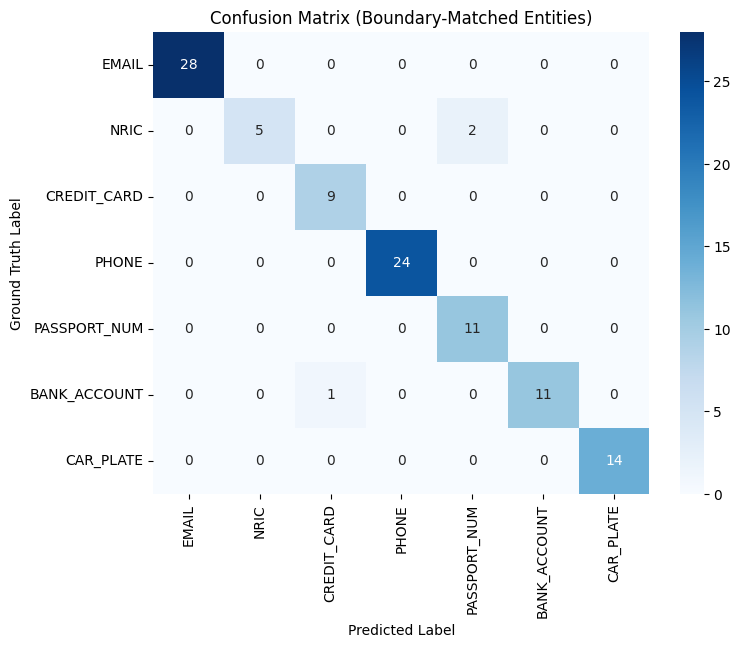

In [205]:
metrics_dict, cm = evaluate_entity_metrics_with_confusion(
        dataset_processed, 
        gt_col="text_entities", 
        pred_col="zero_shot_tagging_entities", 
        labels=ALLOWED_LABELS
    )

# Print the results
print_entity_metrics(metrics_dict)

# Plot the confusion matrix
plot_confusion_matrix(cm, ALLOWED_LABELS)

#### 3.3.3.2 Evaluating Against Few-Shot-Tagging

Entity-Level Metrics (Exact Boundary & Label):
EMAIL           | Precision: 0.83 | Recall: 0.83 | F1: 0.83 | TP: 29, FP: 6, FN: 6
NRIC            | Precision: 0.41 | Recall: 0.32 | F1: 0.36 | TP: 7, FP: 10, FN: 15
CREDIT_CARD     | Precision: 0.83 | Recall: 0.91 | F1: 0.87 | TP: 10, FP: 2, FN: 1
PHONE           | Precision: 0.76 | Recall: 0.79 | F1: 0.77 | TP: 22, FP: 7, FN: 6
PASSPORT_NUM    | Precision: 0.67 | Recall: 0.42 | F1: 0.52 | TP: 8, FP: 4, FN: 11
BANK_ACCOUNT    | Precision: 0.82 | Recall: 0.93 | F1: 0.87 | TP: 14, FP: 3, FN: 1
CAR_PLATE       | Precision: 0.83 | Recall: 0.79 | F1: 0.81 | TP: 15, FP: 3, FN: 4


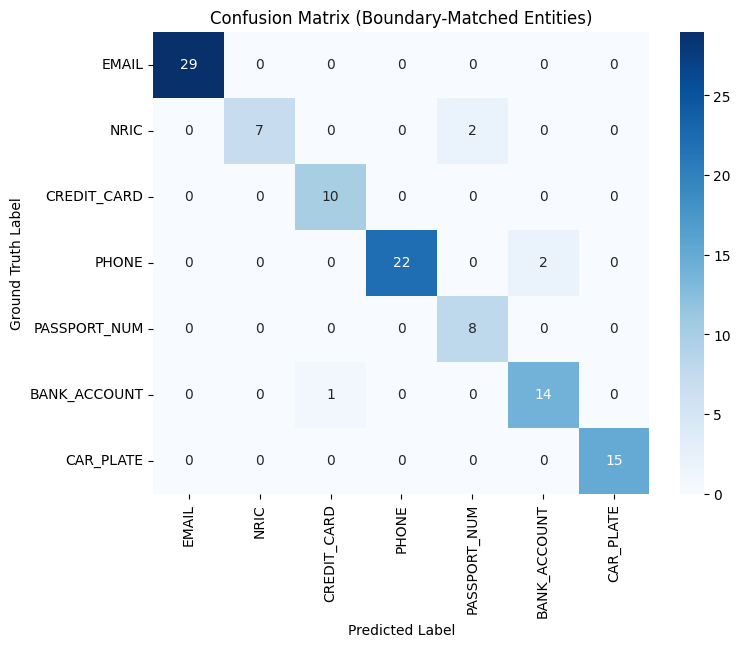

In [206]:
metrics_dict, cm = evaluate_entity_metrics_with_confusion(
        dataset_processed, 
        gt_col="text_entities", 
        pred_col="few_shot_tagging_entities", 
        labels=ALLOWED_LABELS
    )

# Print the results
print_entity_metrics(metrics_dict)

# Plot the confusion matrix
plot_confusion_matrix(cm, ALLOWED_LABELS)

#### 3.3.3.3 Evaluating Against Zero-Shot Chain-of-Thought (CoT) Tagging

Entity-Level Metrics (Exact Boundary & Label):
EMAIL           | Precision: 0.88 | Recall: 0.86 | F1: 0.87 | TP: 30, FP: 4, FN: 5
NRIC            | Precision: 0.39 | Recall: 0.32 | F1: 0.35 | TP: 7, FP: 11, FN: 15
CREDIT_CARD     | Precision: 0.83 | Recall: 0.91 | F1: 0.87 | TP: 10, FP: 2, FN: 1
PHONE           | Precision: 0.87 | Recall: 0.93 | F1: 0.90 | TP: 26, FP: 4, FN: 2
PASSPORT_NUM    | Precision: 0.71 | Recall: 0.79 | F1: 0.75 | TP: 15, FP: 6, FN: 4
BANK_ACCOUNT    | Precision: 0.93 | Recall: 0.93 | F1: 0.93 | TP: 14, FP: 1, FN: 1
CAR_PLATE       | Precision: 0.84 | Recall: 0.84 | F1: 0.84 | TP: 16, FP: 3, FN: 3


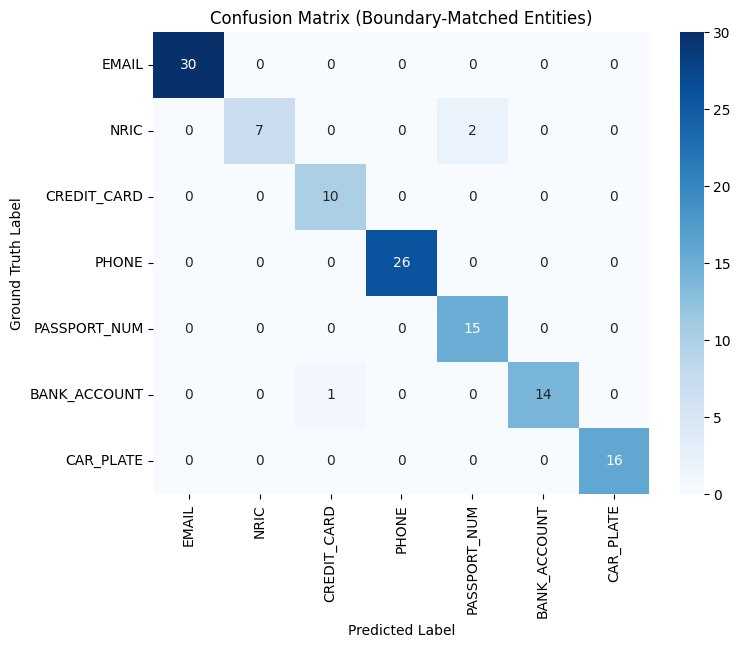

In [207]:
metrics_dict, cm = evaluate_entity_metrics_with_confusion(
        dataset_processed, 
        gt_col="text_entities", 
        pred_col="zero_shot_cot_entities", 
        labels=ALLOWED_LABELS,
    )

# Print the results
print_entity_metrics(metrics_dict)

# Plot the confusion matrix
plot_confusion_matrix(cm, ALLOWED_LABELS)

#### 3.3.3.4 Evaluating Against Few-Shot Chain-of-Thought (CoT) Tagging

Entity-Level Metrics (Exact Boundary & Label):
EMAIL           | Precision: 0.91 | Recall: 0.91 | F1: 0.91 | TP: 32, FP: 3, FN: 3
NRIC            | Precision: 0.39 | Recall: 0.32 | F1: 0.35 | TP: 7, FP: 11, FN: 15
CREDIT_CARD     | Precision: 0.83 | Recall: 0.91 | F1: 0.87 | TP: 10, FP: 2, FN: 1
PHONE           | Precision: 0.83 | Recall: 0.86 | F1: 0.84 | TP: 24, FP: 5, FN: 4
PASSPORT_NUM    | Precision: 0.62 | Recall: 0.68 | F1: 0.65 | TP: 13, FP: 8, FN: 6
BANK_ACCOUNT    | Precision: 0.86 | Recall: 0.80 | F1: 0.83 | TP: 12, FP: 2, FN: 3
CAR_PLATE       | Precision: 0.72 | Recall: 0.68 | F1: 0.70 | TP: 13, FP: 5, FN: 6


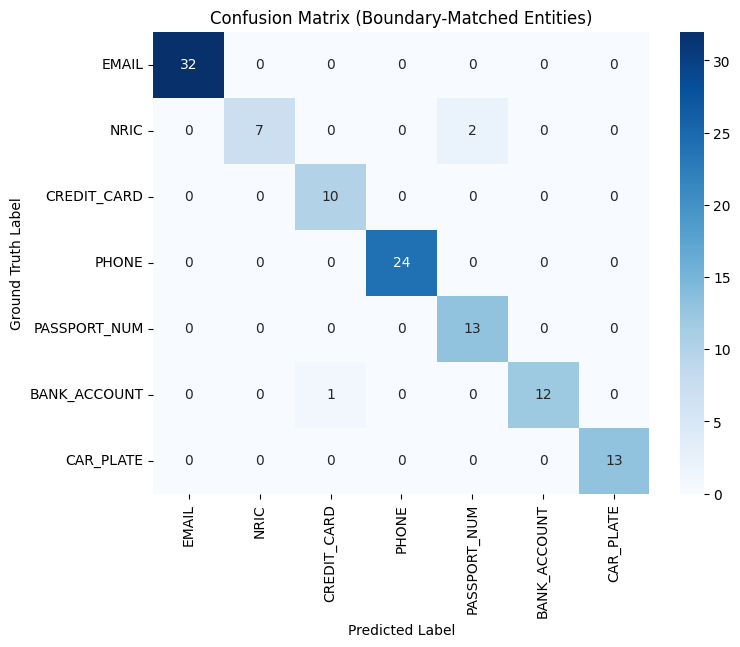

In [208]:
metrics_dict, cm = evaluate_entity_metrics_with_confusion(
        dataset_processed, 
        gt_col="text_entities", 
        pred_col="few_shot_cot_entities", 
        labels=ALLOWED_LABELS,
    )

# Print the results
print_entity_metrics(metrics_dict)

# Plot the confusion matrix
plot_confusion_matrix(cm, ALLOWED_LABELS)

#### Overall F1 scores

| Entity         | Zero-shot ICL | Few-shot ICL | Zero-shot CoT | Few-shot CoT |
|----------------|----------------|---------------|----------------|----------------|
| EMAIL          | 0.78           | 0.83          | 0.87           | **0.91**       |
| NRIC           | 0.25           | **0.36**      | 0.35           | 0.35           |
| CREDIT_CARD    | 0.69           | **0.87**      | **0.87**       | **0.87**       |
| PHONE          | 0.81           | 0.77          | **0.90**       | 0.84           |
| PASSPORT_NUM   | 0.52           | 0.52          | **0.75**       | 0.65           |
| BANK_ACCOUNT   | 0.71           | **0.87**      | **0.93**       | 0.83           |
| CAR_PLATE      | 0.78           | 0.81          | **0.84**       | 0.70           |

- After evaluating four prompting strategies for conversational PII tagging, Zero-Shot Chain-of-Thought (CoT) emerged as the top performer in terms of F1 score across majority of entity types.

- Zero-shot CoT achieved top scores for:
	- CREDIT_CARD (0.87) -> Same as Few-Shot CoT & Few-Shot ICL
	- PHONE (0.90)
	- PASSPORT NUM (0.75)
	- BANK_ACCOUNT (0.93)
	- CAR_PLATE (0.84)

- Zero-shot CoT achieved second highest F1 score for EMAIL (0.87), second only to Few-shot CoT.

- Challenging Entity Types
	- NRIC consistently had the lowest F1 scores across all strategies (0.25 - 0.36)
	- This is primary due to boundary errors. Example:
		- Ground Truth: 
			- Here is the NRIC, [NRIC_START] S 8978801 C [NRIC_END] I wrote it down just in case,\" she handed over a crumpled piece of paper
		- Prediction:
			- Here is the NRIC, S [NRIC_START] 8978801 C [NRIC_END] I wrote it down just in case, " she handed over a crumpled piece of paper
		- The above example shows that grouping the NRIC (perhaps during the LLM correction phase) as one (e.g., S 8978801 C -> S8978801C) can probably improve performance due to the way LLM tokenizations work.

- Conclusion
	- Thought Generation (CoT) showcases improved performance generally across all categories, possibly due to having the LLM understand the entities, and structure of the text prior to tagging.
	- The current test set assumes raw ASR outputs, which challenges the LLM to discern structure. As we are now assuming that the LLM correction module corrects for structure of the PIIs, should we construct a larger test dataset containing already structured PIIs to see how well this works with CoT?
	- Should we also explore Supervised Fine Tuning (SFT) with LoRA?